In [1]:
import scanpy as sc
# Read 10x dataset
adata = sc.read_10x_h5("neuron_10k_v3_filtered_feature_bc_matrix.h5")
# Make variable names (in this case the genes) unique
adata.var_names_make_unique()

Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


# Filtering 

In [2]:
sc.tl.pca(adata)

... storing 'feature_types' as categorical
... storing 'genome' as categorical


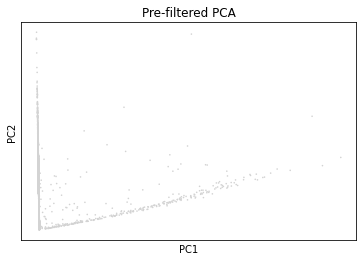

In [3]:
sc.pl.pca(adata, title = "Pre-filtered PCA")

In [4]:
#filter using approach from zheng '17
post_data =sc.pp.recipe_zheng17(adata,copy=True)

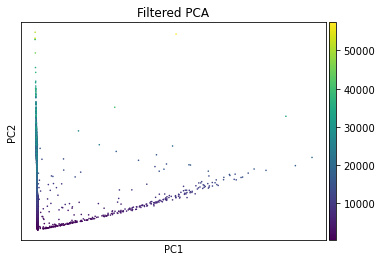

In [5]:
pca=sc.tl.pca(post_data,copy=True)
sc.pl.pca(post_data,title="Filtered PCA",color='n_counts_all')
#legend refers to read count

# Clustering

In [6]:
sc.pp.neighbors(pca, n_neighbors=10, n_pcs=40)
sc.tl.leiden(pca)

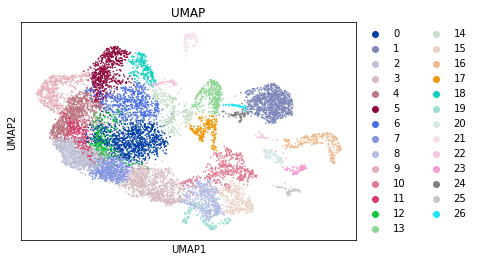

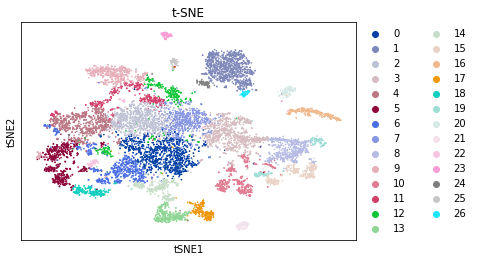

In [7]:
sc.tl.umap(pca)
sc.pl.umap(pca,color='leiden',use_raw=False, title='UMAP')
sc.tl.tsne(pca)
sc.pl.tsne(pca, color='leiden',use_raw=False, title='t-SNE')

# Distinguishing genes

/Users/cmdb/miniconda3/envs/scanpy-v2/lib/python3.6/site-packages/scanpy/tools/_rank_genes_groups.py:408: RuntimeWarning: invalid value encountered in log2
  foldchanges[global_indices]


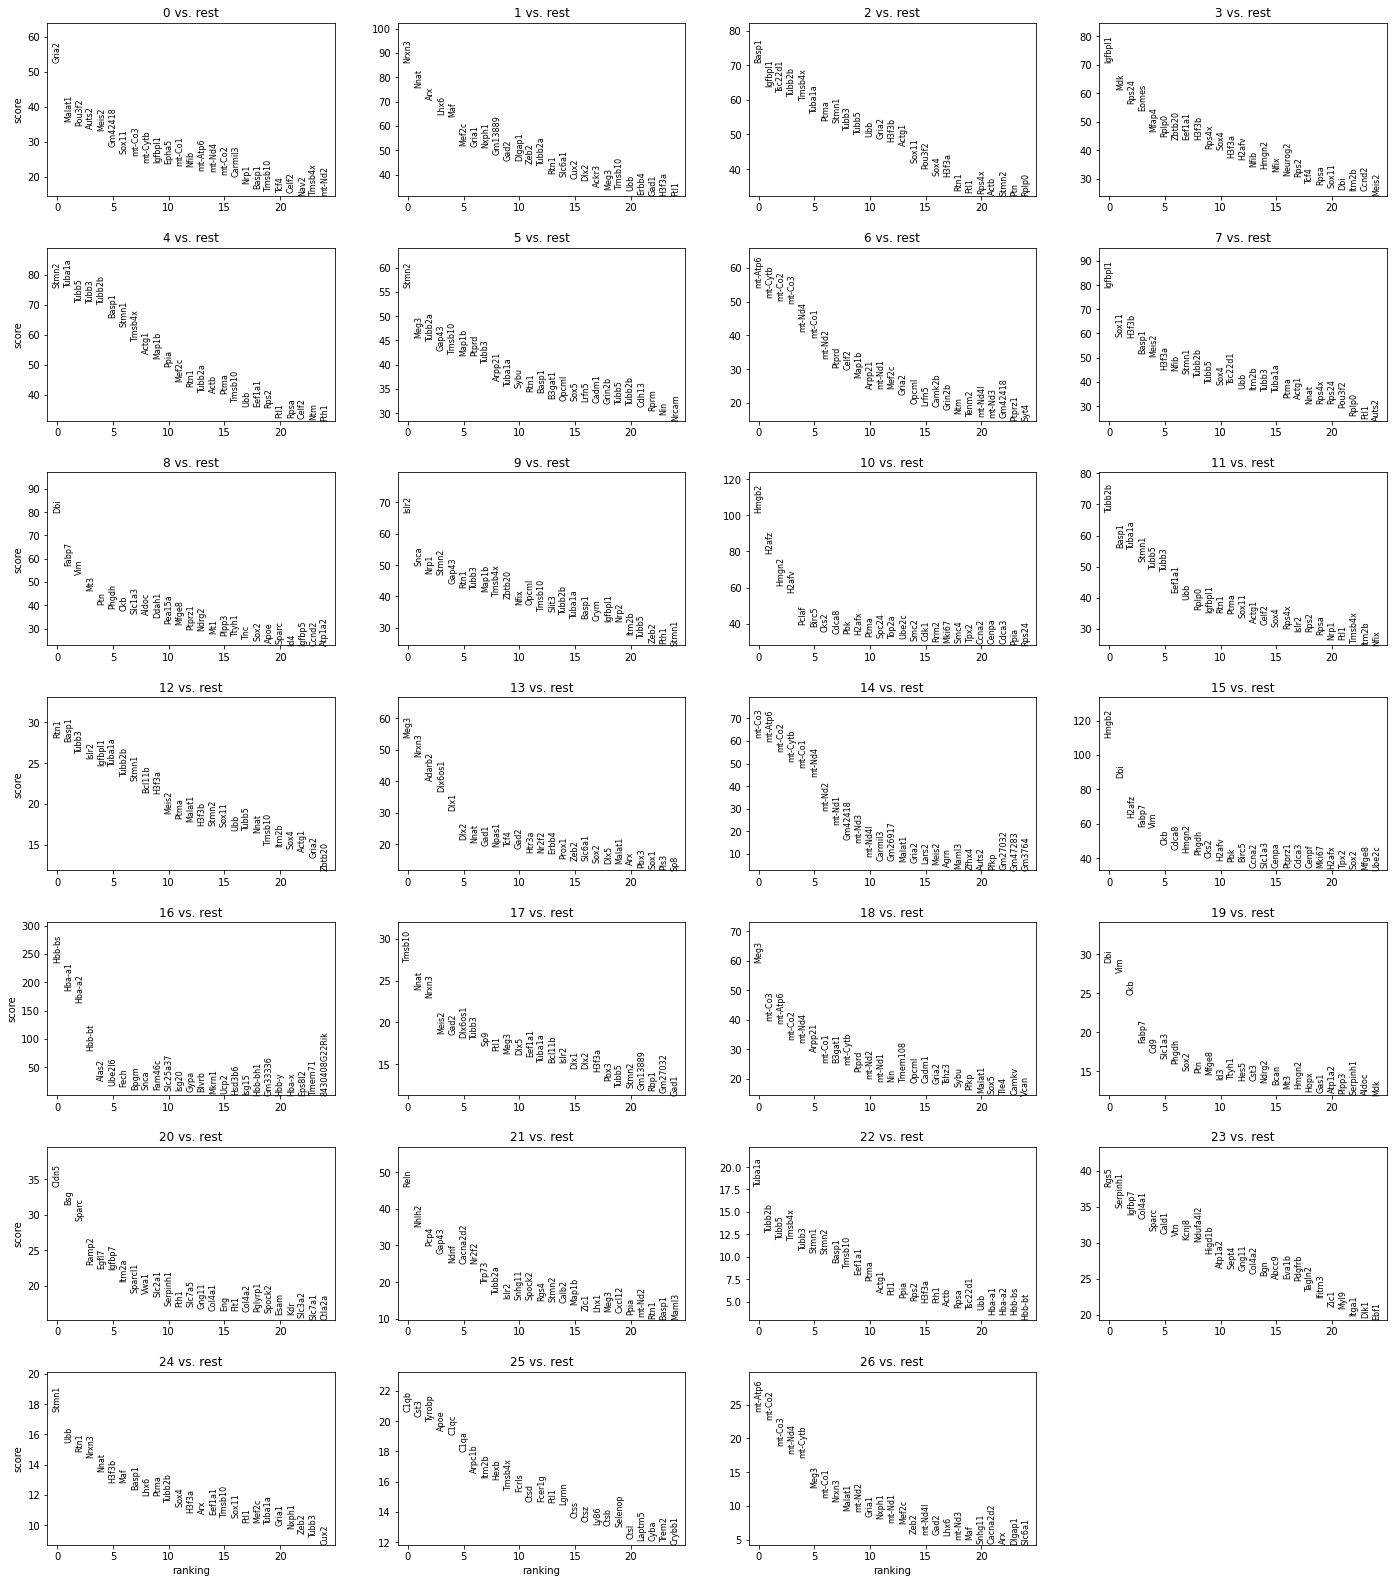

In [8]:
#t-test
sc.tl.rank_genes_groups(pca, 'leiden', method='t-test')
sc.pl.rank_genes_groups(pca, n_genes=25, sharey=False)
pca.write("t-test_genes.csv")

/Users/cmdb/miniconda3/envs/scanpy-v2/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


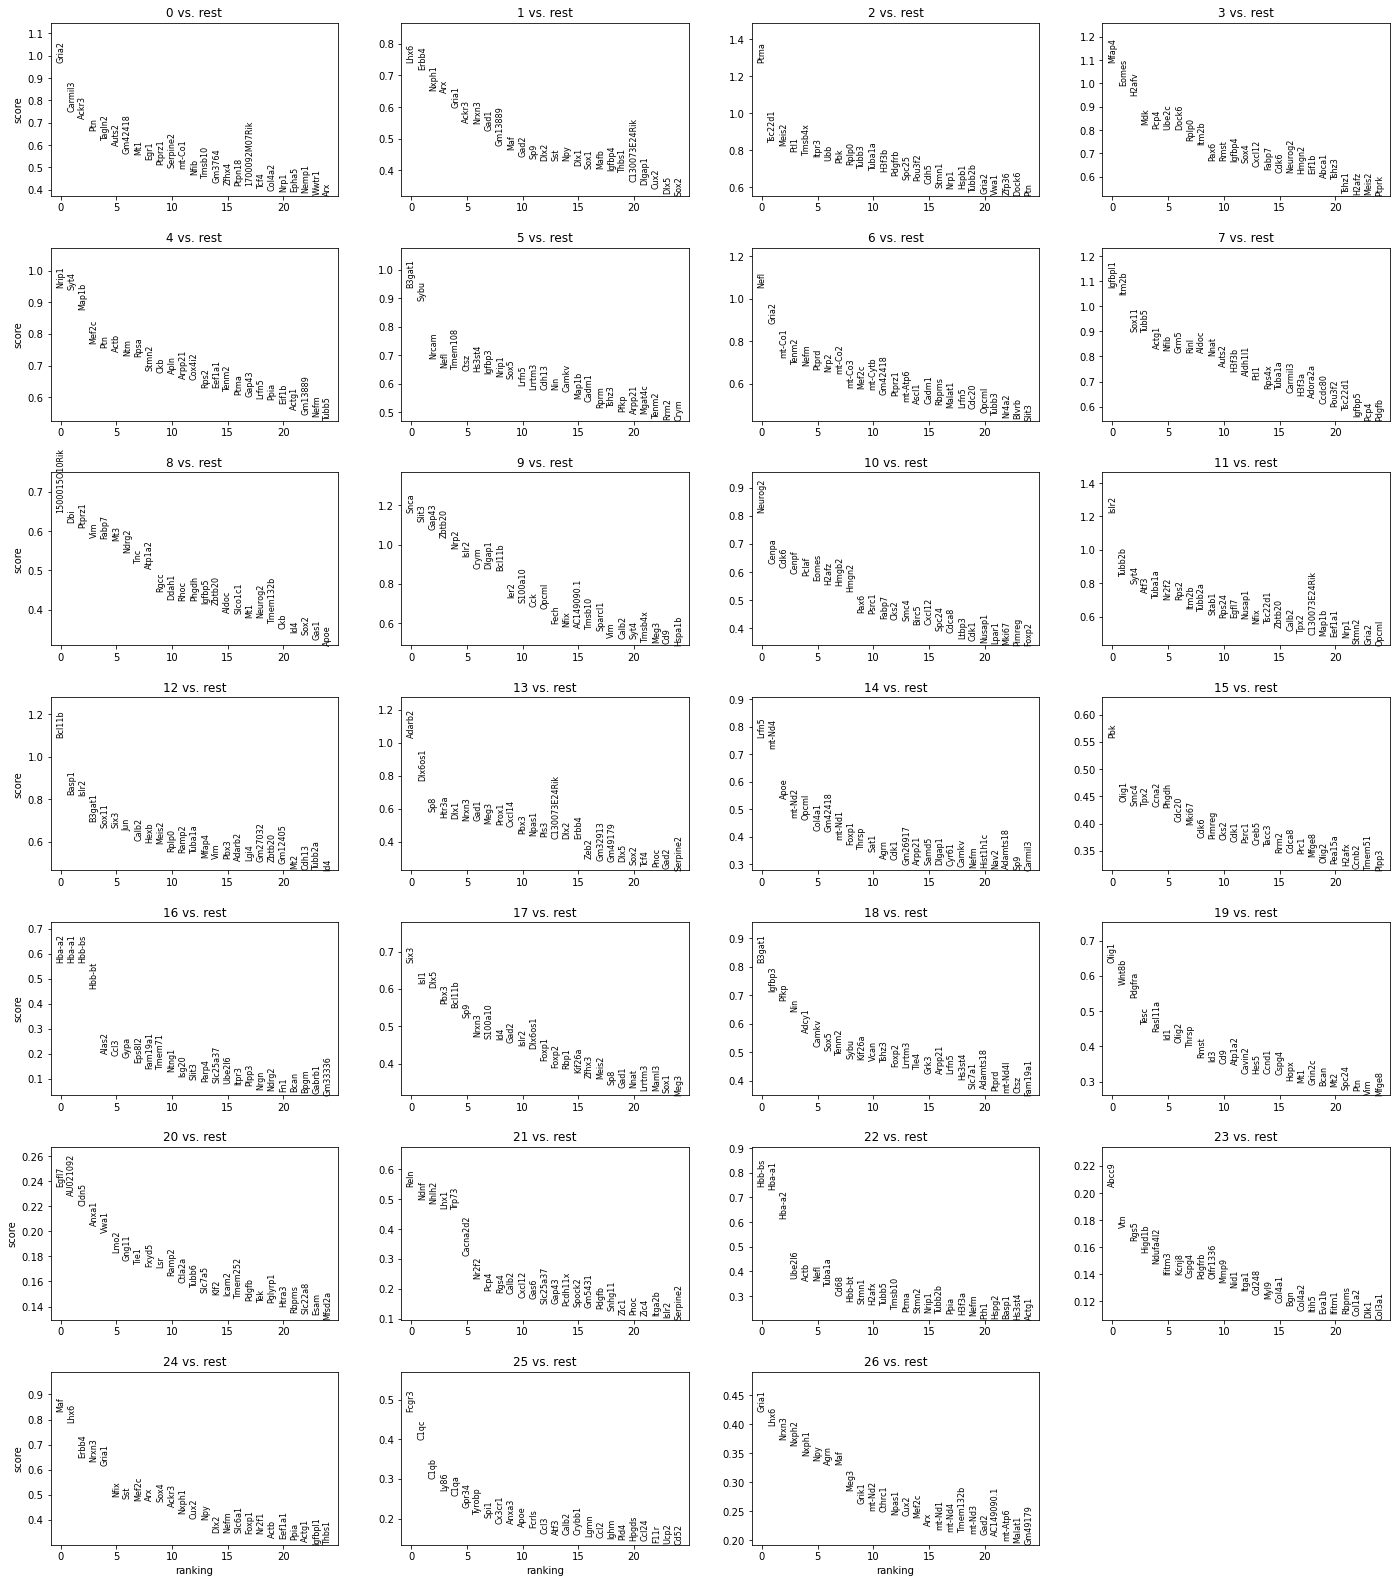

In [9]:
#logistic regression
sc.tl.rank_genes_groups(pca, 'leiden', method='logreg')
sc.pl.rank_genes_groups(pca, n_genes=25, sharey=False)
pca.write("logistic_genes.csv")

# Cell Types!

In [81]:
#make dictionary of cell type markers. many canonical markers were not in this dataset suprisingly, or perhaps used aliases
marker_gene_dict = {'GABAergic interneurons': ['Lhx6'],
                    'T-cells': ['Pbk'],
                     'SVG progenitor cells': ['Eomes'],
                     'Corticospinal Motor Neurons': ['Bcl11b'],
                     'Bergmann glia': ['Zeb2'],
                     'Paraventricular nucleus cells': ['Syt4'],
                     'Astrocytes': ['Pea15a'],
                     'Radial glia': ['Sox2'],
                     'Cholecystokinin interneurons': ['Adarb2'],
                    'Erythrocytes': ['Hbb-bs'],
                   'Oligodendrocytes': ['Olig1'],
                   'Dopaminergic periglomerular neurons': ['Meis2']}

categories: 0, 1, 2, etc.
var_group_labels: GABAergic interneurons, T-cells, SVG progenitor cells, etc.


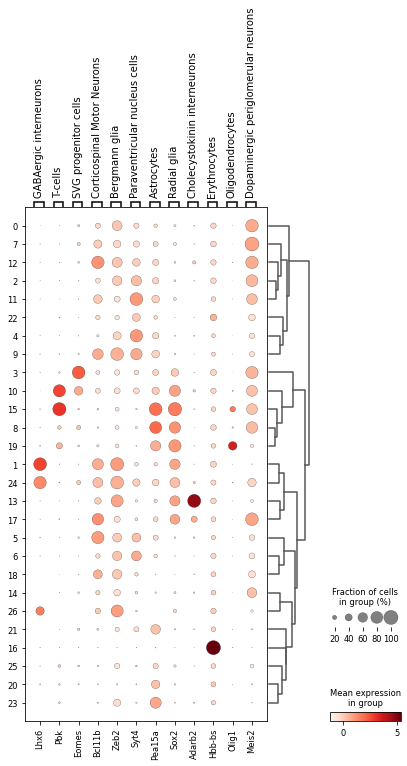

In [82]:
#use dotplot to link cluster groups to cell types
sc.pl.dotplot(pca, marker_gene_dict, 'leiden', dendrogram=True)

In [90]:
#make dictionary linking clusters to cell types
cluster2annotation = {
    '0': 'Dopaminergic periglomerular neurons',
    '1': 'GABAergic interneurons',
    '2': 'Dopaminergic periglomerular neurons',
    '3': 'SVG progenitor cells',
    '4': 'Paraventricular nucleus cells',
    '5': 'Corticospinal Motor Neurons',
    '6': 'Paraventricular nucleus cells',
    '7': 'Dopaminergic periglomerular neurons',
    '8': 'Astrocytes',
    '9': 'Bergmann glia',
    '10': 'T-cells',
    '11': 'Paraventricular nucleus cells',
    '12': 'Corticospinal Motor Neurons',
    '13': 'Cholecystokinin interneurons',
    '14': 'Dopaminergic periglomerular neurons',
    '15': 'T-cells',
    '16': 'Erythrocytes',
    '17': 'Corticospinal Motor Neurons',
    '18': 'Bergmann glia',
    '19': 'Radial glia',
    '20': 'Astrocytes',
    '21': 'Astrocytes',
    '22': 'Paraventricular nucleus cells',
    '23': 'Astrocytes',
    '24': 'GABAergic interneurons',
    '25': 'Astrocytes',
    '26': 'Bergmann glia',
}

In [91]:
#map clusters to annotations in new column called 'cell type'
pca.obs['cell type'] = pca.obs['leiden'].map(cluster2annotation).astype('category')

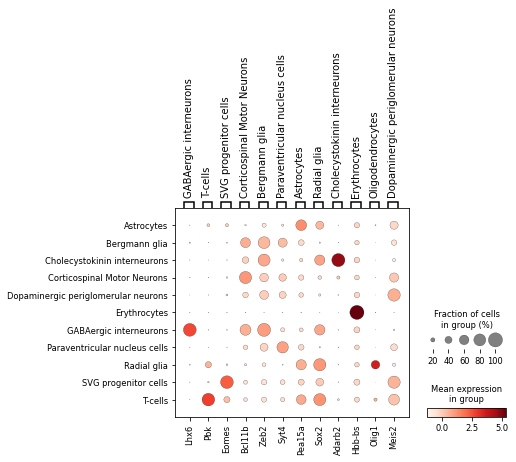

In [92]:
#Cluster condensed dot plot showing differntial expression of markers between cell types
sc.pl.dotplot(pca, marker_gene_dict, 'cell type', dendrogram=False)

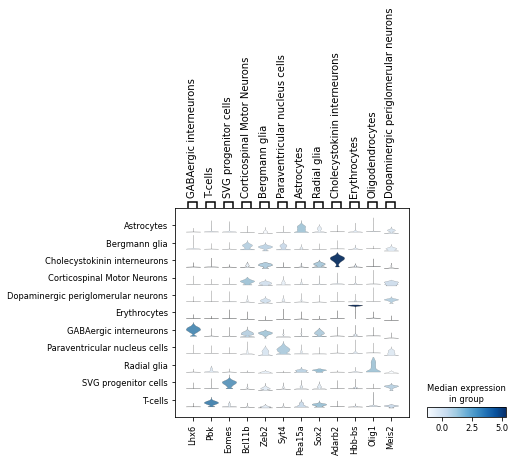

In [101]:
#stacked violin plot for more precise view of differential expression
sc.pl.stacked_violin(pca, marker_gene_dict, groupby='cell type', swap_axes=False, dendrogram=False)

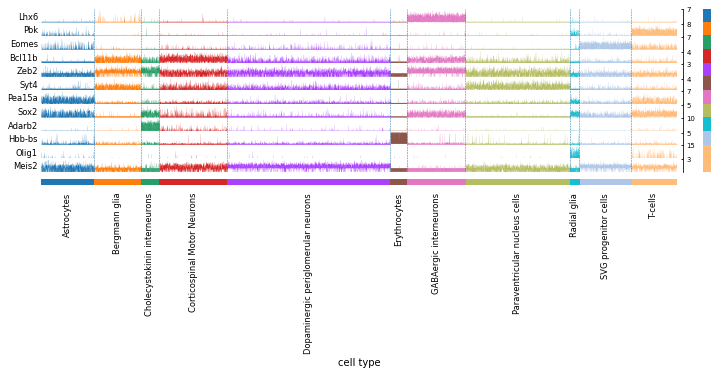

In [95]:
#track plot, which I've never seen before and though was cool
sc.pl.tracksplot(pca ,marker_gene_dict, groupby='cell type', dendrogram=False)

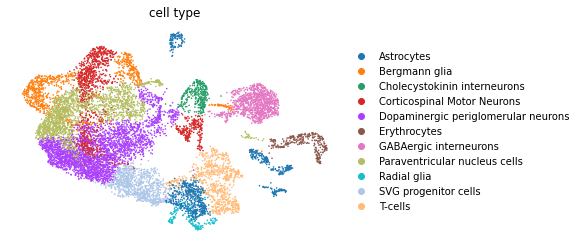

In [103]:
#Final UMAP plot with labeled clusters
sc.pl.umap(pca, color='cell type', legend_loc='right margin', frameon=False, legend_fontsize=10, size = 10)